Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras.models import Model

sns.set()

# Data Preparation

Load the dataset

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Since we have no much computational power, we used only 3 classes instead of 10

In [3]:
labels_to_keep = [i for i in range(3)]  # Replace with the labels you want to keep

# Filter the training set
train_mask = np.isin(y_train, labels_to_keep)
X_train = X_train[train_mask.flatten()]
y_train = y_train[train_mask]

# Filter the test set
test_mask = np.isin(y_test, labels_to_keep)
X_test = X_test[test_mask.flatten()]
y_test = y_test[test_mask]

Normalize data

In [4]:
X_train, X_test = X_train/255, X_test/255

Select Samples

# Apply Style Transfer

Load the Style Transfer Model

In [5]:
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

Load Style Images

In [6]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [7]:
style_images = []
styles = ["cola1.png","Michael-Jackson.jpeg","mumya.jpg","Starry-Night.jpeg", "110.jpg", "farmers.jpeg", "Frida.jpeg", "monroe.png", "p4.jpg", "ss2.jpg", "tomato.png","yellow-flowers.jpeg"]
for style in styles:
    style_images.append(load_image(f"../resized_styles//{style}"))

Convert Images to TensorFlow Type

In [8]:
# Select how many content you want to use to generate samples
content_images = []

for i in range(20):
    content = tf.image.convert_image_dtype(X_train[i], tf.float32)
    content = content[tf.newaxis, :]
    content_images.append(content)

## Generate Positive and Negative Samples

In [9]:
def generate_samples(content_images, style_images, style_transfer_model):
    negative_samples = []
    positive_samples = []
    # Generate positive samples
    for content in content_images:
        for style1 in style_images:
            stylized_image1 = style_transfer_model(tf.constant(content), tf.constant(style1))[0]
            for style2 in style_images:
                if  not (np.array_equal(style1, style2)):
                    stylized_image2 = style_transfer_model(tf.constant(content), tf.constant(style2))[0]
                    positive_samples.append((stylized_image1, stylized_image2))
    
    # Generate negative samples
    for content1 in content_images:
        if random.choice([0,1]) == 0:
            for content2 in content_images:
                if  not (np.array_equal(content1, content2)):
                    for style1 in style_images:
                        stylized_image1 = style_transfer_model(tf.constant(content1), tf.constant(style1))[0]
                        for style2 in style_images:
                            stylized_image2 = style_transfer_model(tf.constant(content2), tf.constant(style2))[0]
                            negative_samples.append((stylized_image1, stylized_image2))
    
    return positive_samples, negative_samples

## Upload Saved Samples (Once you saved the samples, you don't need to run again)

In [10]:
positive_samples, negative_samples = generate_samples(content_images, style_images, model)

#np.save('positive_samples.npy', positive_samples)
#np.save('negative_samples.npy', negative_samples)

In [11]:
# # Load samples
# positive_samples = np.load('positive_samples.npy')
# negative_samples = np.load('negative_samples.npy')

In [12]:
print(f"Number of positive samples: {positive_samples.shape[0]}")
print(f"Number of negative samples: {negative_samples.shape[0]}")

Number of positive samples: 2640
Number of negative samples: 16416


## VISUALIZATION

In [13]:
def plot_images_side_by_side(images):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(images[0][0])
    axs[0].axis('off')
    axs[0].set_title('Image 1')
    axs[1].imshow(images[1][0])
    axs[1].axis('off')
    axs[1].set_title('Image 2')
    plt.show()

#### Positive Pair Example

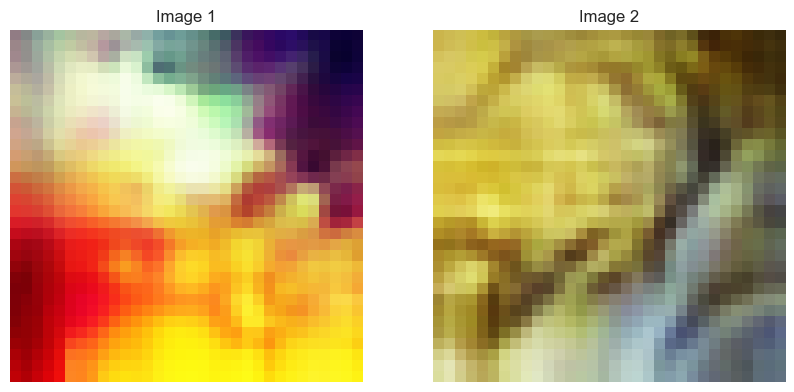

In [14]:
plot_images_side_by_side(positive_samples[500])

#### Negative Pair Example

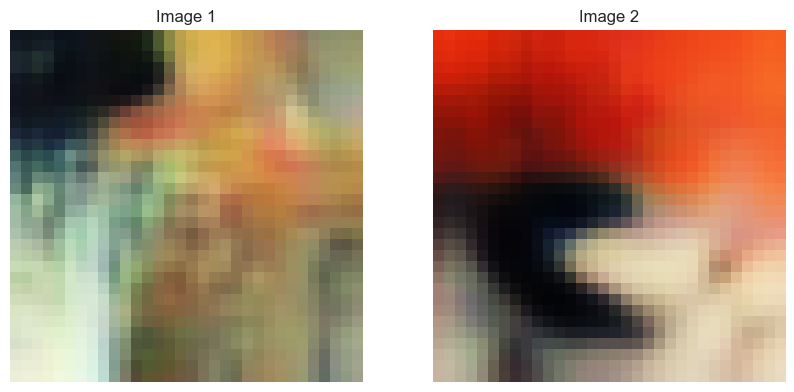

In [15]:
plot_images_side_by_side(negative_samples[50])

# Contrastive Model

In [16]:
# Define the contrastive model architecture
def create_contrastive_model(input_shape_content, input_shape_style, embedding_dim):
    input_content = tf.keras.Input(shape=input_shape_content)
    input_style = tf.keras.Input(shape=input_shape_style)
    
    # Content branch
    x_content = layers.Conv2D(32, (3, 3), activation='relu')(input_content)
    x_content = layers.MaxPooling2D((2, 2))(x_content)
    x_content = layers.Conv2D(64, (3, 3), activation='relu')(x_content)
    x_content = layers.MaxPooling2D((2, 2))(x_content)
    x_content = layers.Flatten()(x_content)
    x_content = layers.Dense(embedding_dim, activation='relu')(x_content)
    
    # Style branch
    x_style = layers.Conv2D(32, (3, 3), activation='relu')(input_style)
    x_style = layers.MaxPooling2D((2, 2))(x_style)
    x_style = layers.Conv2D(64, (3, 3), activation='relu')(x_style)
    x_style = layers.MaxPooling2D((2, 2))(x_style)
    x_style = layers.Flatten()(x_style)
    x_style = layers.Dense(embedding_dim, activation='relu')(x_style)
    
    # Concatenate content and style embeddings
    concatenated = layers.Concatenate()([x_content, x_style])
    
    flattened = layers.Flatten()(concatenated)
    # Normalize the concatenated embeddings
    normalized = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(concatenated)
    
    # Create the model with inputs and outputs
    model = tf.keras.Model(inputs=[input_content, input_style], outputs=normalized)
    return model


# 
def contrastive_loss(y_true, y_pred, margin=0.5):
    square_pred = tf.square(1 - y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square) 

Create Contrastive Model

In [17]:
contrastive_model = create_contrastive_model(input_shape_content=(32, 32, 3),
                                             input_shape_style=(32, 32, 3),
                                             embedding_dim=128)

In [18]:
positive_samples = np.array(positive_samples)
negative_samples = np.array(negative_samples)

In [19]:
content_images_positive = positive_samples[:, 0]
stylized_images_positive = positive_samples[:, 1]
content_images_negative = negative_samples[:, 0]
stylized_images_negative = negative_samples[:, 1]
positive_labels = np.ones(len(positive_samples))
negative_labels = np.zeros(len(negative_samples))
train_images_content = np.concatenate((content_images_positive, content_images_negative))
train_images_style = np.concatenate((stylized_images_positive, stylized_images_negative))
train_labels_content = np.concatenate((positive_labels, negative_labels))

train_images_content = np.squeeze(train_images_content, axis=1)
train_images_style = np.squeeze(train_images_style, axis=1)

# Shuffle the data
indices = np.random.permutation(len(train_images_content))
train_images_content = train_images_content[indices]
train_images_style = train_images_style[indices]
train_labels_content = train_labels_content[indices]

# Select random samples for test data
num_test_samples = min(len(positive_samples) + len(negative_samples), len(X_test))
test_indices = np.random.choice(len(train_images_content), size=num_test_samples, replace=False)
test_images_content = train_images_content[test_indices]
test_images_style = train_images_style[test_indices]
test_labels_content = train_labels_content[test_indices]

# Remove the selected test samples from the training set
train_images_content = np.delete(train_images_content, test_indices, axis=0)
train_images_style = np.delete(train_images_style, test_indices, axis=0)
train_labels_content = np.delete(train_labels_content, test_indices)

# Prepare the training data
train_data = ([train_images_content, train_images_style], train_labels_content)

# Prepare the test data
test_data = ([test_images_content, test_images_style], test_labels_content)

# Split the train_data into content and style inputs
train_content_images = train_data[0][0]
train_style_images = train_data[0][1]
train_labels = train_data[1]

test_content_images = test_data[0][0]
test_style_images = test_data[0][1]
test_labels = test_data[1]

# TEST

In [20]:
contrastive_model.compile(optimizer='adam', loss=contrastive_loss)
contrastive_model.fit([train_content_images, train_style_images], train_labels, epochs=10)

Epoch 1/10
502/502 [==============================] - 14s 27ms/step - loss: 0.2907
Epoch 2/10
502/502 [==============================] - 13s 27ms/step - loss: 0.2904
Epoch 3/10
502/502 [==============================] - 13s 27ms/step - loss: 0.2904
Epoch 4/10
502/502 [==============================] - 13s 27ms/step - loss: 0.2904
Epoch 5/10
502/502 [==============================] - 14s 27ms/step - loss: 0.2904
Epoch 6/10
502/502 [==============================] - 14s 27ms/step - loss: 0.2904
Epoch 7/10
502/502 [==============================] - 13s 27ms/step - loss: 0.2904
Epoch 8/10
502/502 [==============================] - 13s 27ms/step - loss: 0.2904
Epoch 9/10
502/502 [==============================] - 14s 27ms/step - loss: 0.2904
Epoch 10/10
502/502 [==============================] - 14s 28ms/step - loss: 0.2904


In [21]:
from keras.layers import Flatten
from keras.layers import Dense
from keras.utils import to_categorical

base_model = contrastive_model.layers[0]

# Add a new Flatten layer to our base model
flattened = Flatten()(base_model.output)

# Add a new classification layer to the flattened output
output_layer = Dense(3, activation='softmax')(flattened)

# Create a new classification model
classification_model = Model(inputs=base_model.input, outputs=output_layer)
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)
# Now we can compile and train this model
classification_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = classification_model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test), batch_size=20)

Epoch 1/10
750/750 [==============================] - 1s 1ms/step - loss: 0.8583 - accuracy: 0.6343 - val_loss: 0.7873 - val_accuracy: 0.6663
Epoch 2/10
750/750 [==============================] - 1s 1ms/step - loss: 0.7935 - accuracy: 0.6703 - val_loss: 0.9418 - val_accuracy: 0.6257
Epoch 3/10
750/750 [==============================] - 1s 1ms/step - loss: 0.7714 - accuracy: 0.6833 - val_loss: 0.7291 - val_accuracy: 0.7060
Epoch 4/10
750/750 [==============================] - 1s 1ms/step - loss: 0.7747 - accuracy: 0.6809 - val_loss: 0.7034 - val_accuracy: 0.7170
Epoch 5/10
750/750 [==============================] - 1s 1ms/step - loss: 0.7595 - accuracy: 0.6874 - val_loss: 0.7500 - val_accuracy: 0.6980
Epoch 6/10
750/750 [==============================] - 1s 1ms/step - loss: 0.7480 - accuracy: 0.6977 - val_loss: 0.8531 - val_accuracy: 0.6473
Epoch 7/10
750/750 [==============================] - 1s 1ms/step - loss: 0.7435 - accuracy: 0.6992 - val_loss: 0.7388 - val_accuracy: 0.6900
Epoch 

## VISUALIZATION

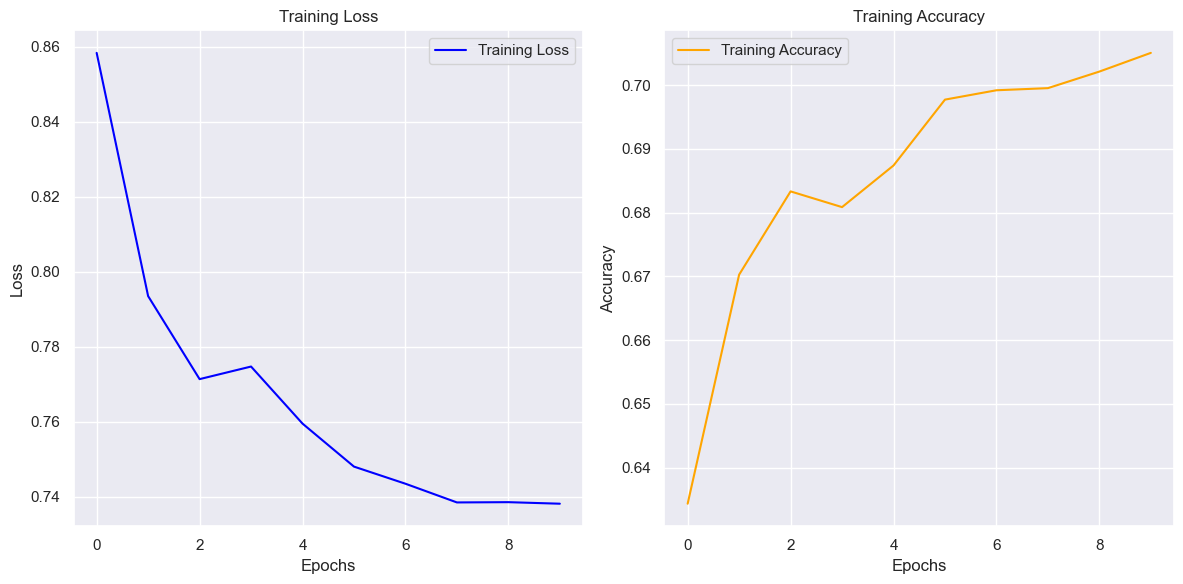

In [22]:
def plot_history(history):
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the training loss curve
    ax1.plot(train_loss, label='Training Loss', c="blue")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()

    # Plot the training accuracy curve
    ax2.plot(train_accuracy, label='Training Accuracy', c="orange")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Accuracy')
    ax2.legend()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
    
plot_history(history)

## Testing on Test Data

In [23]:
preds = classification_model.predict(X_test, verbose=0) # Model predictions
pred_labels = np.argmax(preds, axis=1) # Prediction Labels

y_test_labels = np.argmax(y_test, axis=1) # y_test labels

accuracy = np.mean(pred_labels == y_test_labels)

print(f"Accuracy: {accuracy}")

Accuracy: 0.6496666666666666
